# Week 2

The most accessible way to measure brain activity is using electrodes placed on the scalp, referred to as electroencephalography (EEG). These are weak signals, on the order of X uV, which is ~100,000 times weaker than the voltage of a AAA battery. To measure these we use specialized electrodes and amplifiers. Since this course is focused on the signal and data analysis end of BCI, we will not 

In [1]:
import os.path as op
import pandas as pd
import numpy as np
import scipy.io as sio
import scipy.signal as ss
import matplotlib.pyplot as plt

## Acquisition of EEG
EEG was one of the first widely accesible ways to track the activity of awake behaving subjects. It was developed in the 1920s by Hans Berger. He found that by inserting metal electrodes into the scalp, he was able to detect extremely weak electrical signals. While initially dismissed by the scientific community, he work was subsequently validated by the prominent neurophysiologist E.D. Adrien. Given the ease of obtaining the EEG signal, and that it did not require opening up the skull, it rapidly became a widespread tool for the study of brain activity. Today, it is commonly used in medicine to help diagnose medical conditions, such as epilepsy, characterize sleep distrubances using polysomnography, and in research labs to further our understanding of brain function. It is also a technique for studying brain activity that is readily accessible to the amature, with many companies selling do-it-yourself EEG recording kits (e.g. X). For a thorough manual on acquiring and interpreting EEG signals check out https://academic.oup.com/book/35515.

### EEG signal
As we reviewed in Week 1, the transmembrane currents of neurons produce voltages that can be picked up by electrodes. As those electrodes are moved farther away from the neurons, this voltage falls off. When ones electrode reaches the surface of the scalp, the voltages from individual neurons are so weak that they cannot be distinguished from each other. Instead, it is the shared transmembrane currents across all the neurons within several centimeters of the electrode that make up the EEG signal. We saw that the very large currents contributed to the action potentials of single neurons were not visible once we were 2 cm from the neurons, but the shared slow fluctuations and synaptic currents were evident. It is estimated that the total area of cortex required to be coactivated sufficiently to generate a detectable scalp potential is around 6 cm<sup>2</sup> (Ebersole 1997). Consequently, the EEG reflects widespread activations.

Our simplified model ignored a few details that apply to real brains and that influence the EEG. First, neurons are not 'point-sources', i.e. they are not a single current source but have dendrites that currents also flow through. This create a dipole that influenes the distribution of transmembrane currents and the voltages recorded at the scalp. Second, the cortical surface has a convoluted surface, with neurons oriented at different angles with respect to the scalp. This angling affects both the magnitude and the sign of voltage picked up on the scalp, making it exceptionally difficult to reconstruct exactly what neural sources generated any recorded potential. Lastly, we assumed that the conductivity of the tissue between the neuron and the scalp electrode was Ohmic (homogenous), but this is not the case. A neural potential passes through brain tissue, the cerebrospinal fluid, dura mater that encapsulates the brain, bone of the skull, and the skin. These tissues have different conductivities, further complicating the reconstruction of the underlying neural generators.

### Electrode placement
While it is not possible to exactly reconstruct the EEG sources, by placing multiple electrodes across the scalp one can observe some coarse localization of brain activity (see https://robertoostenveld.nl/electrode/#jasper1958 for a nice discussion). For instance, presenting an auditory stimulus elicits a potential over the portion of the scalp overlying the temporal lobe, where auditory cortex is, while visual stimuli elicit potentials over occipital cortex, where visual cortex is [CITATIONS]. So, there seems to be some loose relationship between a signal in the EEG and the source of that signal. This highlights the need to place multiple electrodes over the scalp to get a complete picture of the brain activity. 

In 1958 a standard was adopted for placement and naming of EEG electrodes with respect to features on the skull. It has been updated periodically over the decades (https://journals.lww.com/clinicalneurophys/Citation/1994/01000/Guideline_Thirteen__Guidelines_for_Standard.14.aspx), with the most recent incarnation known as the 10-20 system. The 10 refers to the percent distance between adjacent electrodes along the front-back axis of the skull (also referred to as rostro-caudal or anterior-posterior). 20 refers to the percent distance between adjacent electrodes along the left-right axis of the skull (also referred to as medial-lateral). Electrodes are named with a combination of letters and numbers. Each starts with letters corresponding to the region of the brain they lie immediately over:
|Letters|Region|
|-----|----|
|Fp| Prefrontal|
|F| Frontal|
|C| Central|
|T| Temporal|
|P| Parietal|
|O| Occipital|

Each is followed by a number or the letter 'z'. 'z' is used for sites along the midline, even numbers on the right hemisphere, and odd numbers on the left hemisphere. The numbers start at 1 and increase as electrode sites are moved away from the midline, i.e. laterally. This layout looks like:
[IMAGE OF 10-20 SYSTEM]

Recently, the number of recording sites has increased because of advances the miniaturization of recording systems. The recordings we will draw from for these lectures use the 10-20 extended system, that features more recording sites. In addition to the names used above, also included are sites prefixed with FC (frontal-central) and PO (parietal-occipital). Its layout is:
[IMAGE OF EXTENDED 10-20 SYSTEM]

In addition to electrodes that are explicitly targeted to record brain activity, additional electrodes are used for referencing and detection of contaminating noise and artifacts.

### Referencing and montages
Since voltage is a measure of the work needed to move a charge from one place to another, it is always measured between two points. Ideally, one of our points would be at a point in space that is infinitely far away from the electrode and with no charges near it to contaminate the potential we are attempting to measure at the EEG site. This is not practical (nor would it work due to the ability of recording hardware to detect exceptionally small currents). In the case of EEG, researchers often place an electrode on a subject's ear lobe. The ear lobe does not have any substantial intrinsic electrical activity, and is fairly far from the brain compared with electrodes placed on the scalp. 

### Artifacts and noise
EYE BLINKS, POWERLINE NOISE, EMG
MODEL OF EEG SIGNAL AS EEG = BRAIN_SPON + BRAIN_EVOKED + SCALP SLOW + EMG NOISE + EOG + POWERLINE

## Working with EEG data

### Loading EEG signals
DISCUSS .SET FILE
PLOT STACKED EEG LINES

### Time series data
SAMPLING A CONTINUOUS SIGNAL, SAMPLE RATE, RESOLUTION, MEAN, VARIANCE, AUTOCORRELATION

### Meta data
DISCUSS .SET, .TSV, .JSON
ROUTINES TO LOAD DATA

### Noise removal
BASELINE SUBTRACT, MOVING AVERAGE, CONVOLUTION, FILTERS, 

## Event-related potentials
### Evoking them
EXPERIMENTAL DESIGN, WINDOWING EEG SIGNALS BY EVENTS
### Time course
COMPONENTS, DEFINED BY LATENCY, MAGNITUDE, SIGN, DURATION
VARIABILITY ACROSS REPITITIONS WITH BOOTSTRAPPING
### Topography
EEG HAS GOOD TEMPORAL RESOLUTION, BUT POOR SPATIAL RESOLUTION. LOCALIZE ELECTRODES WHERE ERP COMPONENT IS STRONGEST

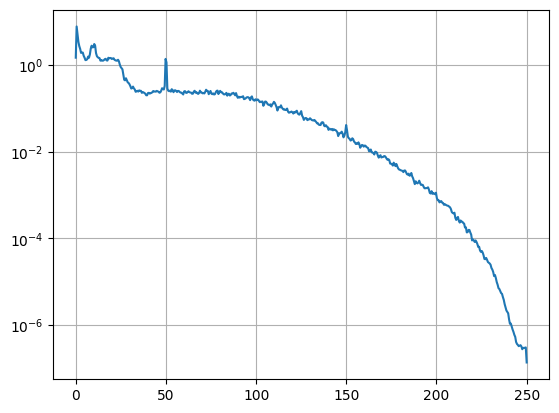

In [2]:
root_dir = '/Users/drewheadley/Documents/Courses/DataScienceProgram/DecodingTheBrain/Datasets/ds003690'
subj = 'AB64'
eeg_file = op.join(root_dir, 'sub-{}/eeg/sub-{}_task-passive_run-1_eeg.set'.format(subj, subj))
evt_file = op.join(root_dir, 'sub-{}/eeg/sub-{}_task-passive_run-1_events.tsv'.format(subj, subj))
#'/Users/drewheadley/Documents/Courses/DataScienceProgram/DecodingTheBrain/Datasets/ds003690/sub-AB4/eeg/sub-AB4_task-passive_run-1_eeg.set'
#evt_file = '/Users/drewheadley/Documents/Courses/DataScienceProgram/DecodingTheBrain/Datasets/ds003690/sub-AB4/eeg/sub-AB4_task-passive_run-1_events.tsv'
eeg = sio.loadmat(eeg_file)
evt = pd.read_csv(evt_file, sep='\t')

samp_rate = eeg['srate'][0][0]
eeg_data = eeg['data']
nchan = eeg_data.shape[0]
nsamp = eeg_data.shape[1]
chan_info = eeg['chaninfo'][0][0][1]
ref_elec = eeg['ref']

evt_times = evt['sample'][evt['trial_type']=='cue'].values
# create a matrix of indices for the 200 ms window around each event
evt_inds = np.tile(evt_times, (int(samp_rate), 1)).T + np.arange(-int(samp_rate/2), int(samp_rate/2))

ind = 40
sel_eeg = eeg_data[ind,:]
f, Pxx_den = ss.welch(sel_eeg, samp_rate, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.grid()

Text(0.5, 1.0, 'CP6 69 7.889221 -0.063045 4.064806   ')

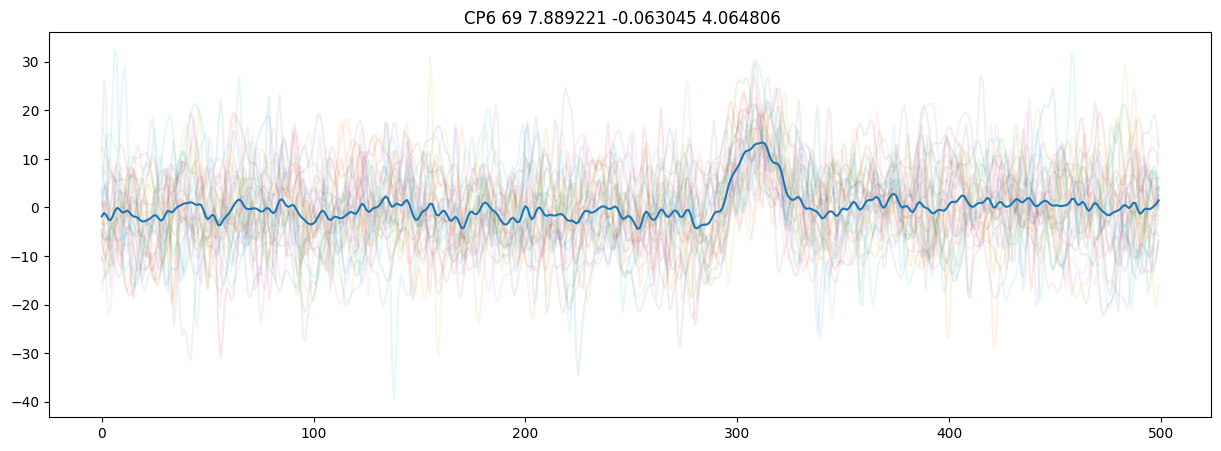

In [451]:
ind = 40
sel_eeg = eeg_data[ind,:]
# apply 60 hz notch filter
b,a = ss.butter(2, 100, btype='low', fs=samp_rate)

#freq, h = ss.freqz(b,a,fs=samp_rate)
#plt.plot(freq, np.abs(h))
'''seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg[0,:], color='k')
sel_eeg = ss.filtfilt(b,a,sel_eeg)
seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg[0,:], color='r')'''

sel_eeg = ss.filtfilt(b,a,sel_eeg)
seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg.T-np.mean(seg_eeg,axis=1), alpha=0.1)
plt.plot(np.mean(seg_eeg.T-np.mean(seg_eeg,axis=1),axis=1))
plt.title(chan_info[ind])

In [ ]:
'''seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg[0,:], color='k')
sel_eeg = ss.filtfilt(b,a,sel_eeg)
seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg[0,:], color='r')'''

sel_eeg = ss.filtfilt(b,a,sel_eeg)
seg_eeg = sel_eeg[evt_inds]
plt.plot(seg_eeg.T-np.mean(seg_eeg,axis=1), alpha=0.1)
plt.plot(np.mean(seg_eeg.T-np.mean(seg_eeg,axis=1),axis=1))
plt.title(chan_info[ind])

In [ ]:
# power specturm of sel_eeg
